###### Case Study

The objective is to use customer data to figure out how to divide the consumer population into the ideal group of clusters.


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Data importing 
df_raw=pd.read_csv('Train.csv')

In [3]:
df_raw.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [4]:
df=df_raw.copy(deep=True)
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


###### Data Processing 

We preprocess the dataset so that it can be inputted into the clustering algorithm. This entails:

- removing unwanted features
- removing missing values
- removing outliers
- encoding categorical features

In [5]:
# import libraries
from scipy import stats
from sklearn.preprocessing import LabelEncoder
# drop unwanted features 
df=df.drop(['Var_1','Segmentation'], axis=1)

In [6]:
# remove missing values 
df=df.dropna()

In [7]:
df.isnull().sum()

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
dtype: int64

In [8]:
# create a set storing outliers
outliers=set()

In [9]:
# Calculate z_scores for age, work_experience, and family_size
scores=pd.DataFrame(columns=['ID','Age','Work_Experience','Family_Size'])
scores['ID']=df['ID']
for var in ['Age','Work_Experience','Family_Size']:
    scores[var]=np.abs(stats.zscore(df[var]))
    scores[var]=np.abs(stats.zscore(df[var]))
    scores[var]=np.abs(stats.zscore(df[var]))

In [10]:
# Find and remove outliers
for i, row in scores.iterrows():
    if np.max(row[['Age','Work_Experience','Family_Size']])>3:
        outliers.add(row['ID'])
df=df[df['ID'].isin(outliers)==False]

In [11]:
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0
5,461319,Male,Yes,56,No,Artist,0.0,Average,2.0
6,460156,Male,No,32,Yes,Healthcare,1.0,Low,3.0


In [12]:
df.shape

(6554, 9)

In [13]:
# keep a copy of this dataset for future visualizaton
df_viz=df.copy(deep=True)

In [14]:
# Encode categorical variable 
le=LabelEncoder()
cat_var=['Gender','Ever_Married','Graduated','Spending_Score']
for var in cat_var:
    df[var]=le.fit_transform(df[var])
df=pd.concat([df, pd.get_dummies(df['Profession'])], axis=1)
df=df.drop('Profession', axis=1)

In [15]:
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing
0,462809,1,0,22,0,1.0,2,4.0,0,0,0,0,0,1,0,0,0
2,466315,0,1,67,1,1.0,2,1.0,0,0,1,0,0,0,0,0,0
3,461735,1,1,67,1,0.0,1,2.0,0,0,0,0,0,0,0,1,0
5,461319,1,1,56,0,0.0,0,2.0,1,0,0,0,0,0,0,0,0
6,460156,1,0,32,1,1.0,2,3.0,0,0,0,0,0,1,0,0,0


#### PCA

After that, the data will undergo normalization and a principal component analysis (PCA). Normalizing the data ensures that the machine learning model is not biased towards any of the features, whereas a PCA will reduce the dimensionality of the dataset to mitigate overfitting.

In [16]:
# import libraries 
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Normalize daa with MinMaxScaler
mms=MinMaxScaler()
X=df.drop('ID', axis=1)
X_mns=mms.fit_transform(X)

# Reduce dimensionnality wiht PCA 
print('Number of features before PCA : {}'.format(len(X_mns[0])))
pca=PCA(.90)
X_pca=pca.fit_transform(X_mns)
print('Number of features after PCA : {}'.format(len(X_pca[0])))

Number of features before PCA : 16
Number of features after PCA : 10


###### Building The Clustering Model

Next, we need to determine the ideal number of clusters for this batch of consumers. This can be easily determined with the elbow method.

While the elbow method can be performed manually, it is made a lot simpler with the yellowbrick library, which can build the visual plot with a single line of code.

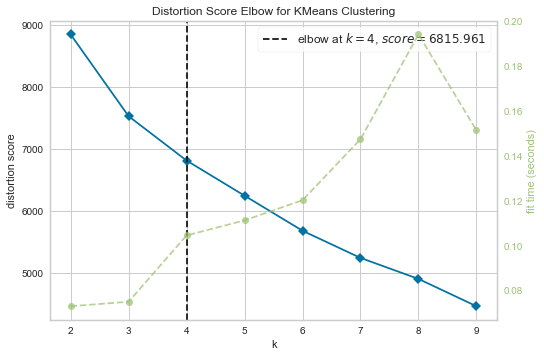

In [18]:
# Import libraries
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Create a kmeans model 
model=KMeans(random_state=42)

# Use the KELbowVisualizer to calculate distortion for different numbers of clusters
visualizer=KElbowVisualizer(model, k=(2,10))
visualizer.fit(X_pca)
visualizer.show()

The elbow method suggests that it will be ideal to divide our consumer population into four groups.

Let’s create a k-means clustering model that assigns each customer to one of four clusters.

In [19]:
# Create a k-means model and assign each customer to a cluster
kmeans=KMeans(n_clusters=4, random_state=42)
prediction=kmeans.fit_predict(X_pca)

To visualize the results of the clustering, we can develop a scatter plot.

The coordinates of the points representing the customers will be based on the first two PCA components.

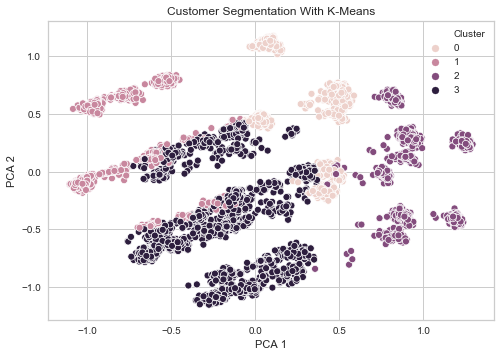

In [20]:
# first PCA component
pca1=[val[0] for val in X_pca]
# second PCA component
pca2=[val[1] for val in X_pca]

# add the cluster and PCA components to the dataframe
df_viz['Cluster']=prediction
df_viz['PCA 1']=pca1
df_viz['PCA 2']=pca2

#plot scatter plot 
sns.scatterplot(data=df_viz, x='PCA 1', y='PCA 2', hue='Cluster')
plt.title('Customer Segmentation With K-Means')
plt.show()

###### Interpretation

At this point, you may be tempted to pat yourself on the back, but the job hasn’t been done yet.

Ask yourself: what have you really learned at this point?

Even though you have separated your consumers into groups, does the manner of the grouping even have any meaning?

If you can not explain the clusters formed by your algorithm, all your efforts are fruitless. For the people you present your findings to, a group of clusters with no well-defined traits is no different from a group of clusters made at random.

The cluster analysis will only have significance if you can explain how your customers are divided. This will allow you to understand each group and then plan a marketing strategy for each group accordingly.

We can use box plots to compare each cluster in terms of age, work experience, and family size.

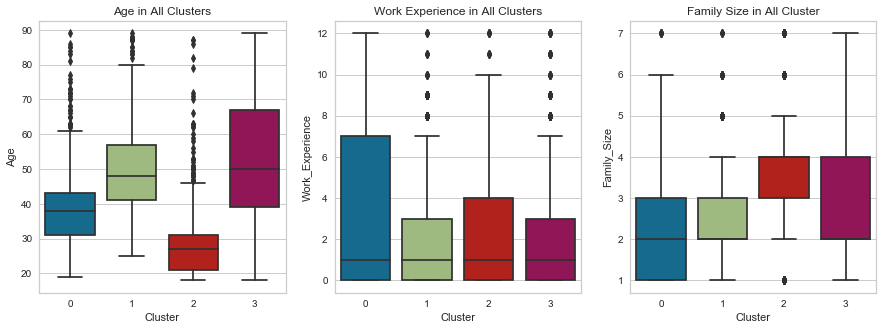

In [24]:
# Create boxplots to show age, work experience, and family size for each cluster
fig, axes=plt.subplots(1,3, figsize=(15,5))
ax=sns.boxplot(ax=axes[0], x='Cluster', y='Age', data=df_viz)
ax.title.set_text('Age in All Clusters')
ax2=sns.boxplot(ax=axes[1], x='Cluster', y='Work_Experience', data=df_viz)
ax2.title.set_text('Work Experience in All Clusters')
ax3=sns.boxplot(ax=axes[2], x='Cluster', y='Family_Size', data=df_viz)
ax3.title.set_text('Family Size in All Cluster')
plt.show()

We can use pie charts to compare each cluster in terms of gender, marital status, graduation status, profession, and spending score.

For convenience, we can create a function that generates pie charts comparing clusters in terms the given feature.

In [25]:
# create a function to generate pie charts for a given categorical feature
def cluster_demographic(var):
    
    # Create subsets for each cluster
    df_0 = df_viz[df_viz['Cluster']==0]
    df_1 = df_viz[df_viz['Cluster']==1]
    df_2 = df_viz[df_viz['Cluster']==2]
    df_3 = df_viz[df_viz['Cluster']==3]

    fig, ax = plt.subplots(2, 2)


    ax[0,0].pie(df_0[var].value_counts(), labels=df_0[var].value_counts().index)
    ax[0,0].title.set_text('Cluster 0')
    ax[0,1].pie(df_1[var].value_counts(), labels=df_1[var].value_counts().index)
    ax[0,1].title.set_text('Cluster 1')
    ax[1,0].pie(df_2[var].value_counts(), labels=df_2[var].value_counts().index)
    ax[1,0].title.set_text('Cluster 2')
    ax[1,1].pie(df_3[var].value_counts(), labels=df_3[var].value_counts().index)
    ax[1,1].title.set_text('Cluster 3')
    plt.suptitle(var)

    plt.show()

The pie charts comparing the clusters are shown below.

Gender:

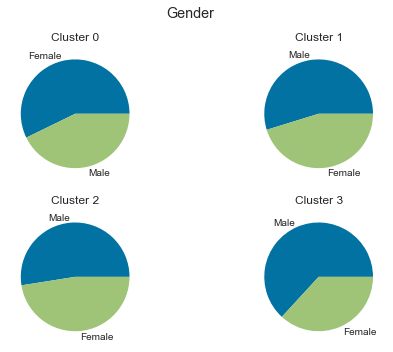

In [26]:
# Comparing clusters based on gender
cluster_demographic('Gender')

Marital Status:

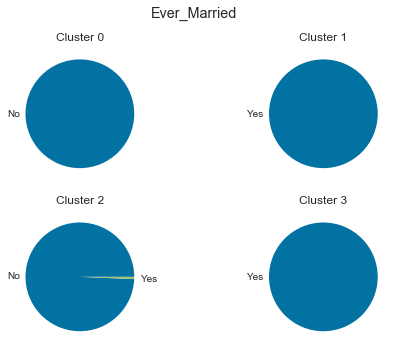

In [27]:
# Comparing clusters based on marital status
cluster_demographic('Ever_Married')

Graduation Status:

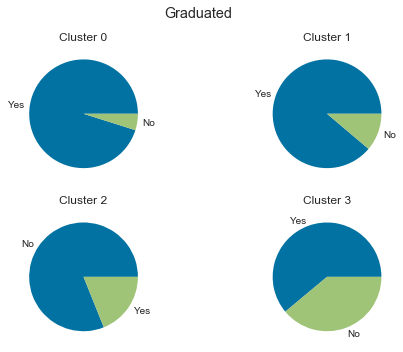

In [28]:
# Comparing clusters based on graduation status
cluster_demographic('Graduated')

Profession:

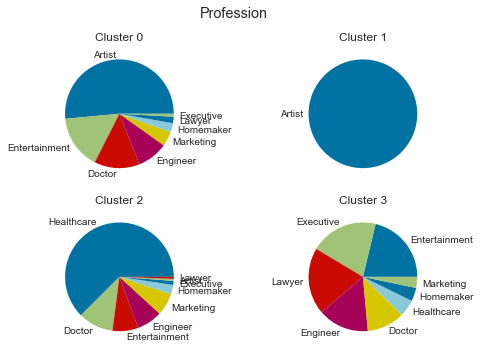

In [30]:
# Comparing clusters based on profession
cluster_demographic('Profession')

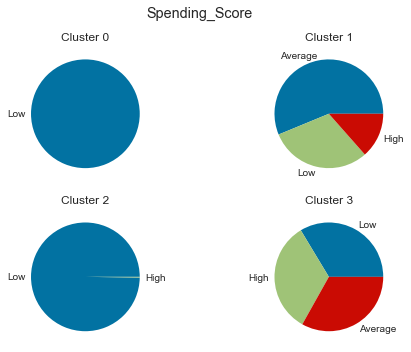

In [31]:
# Comparing clusters based on spending score 
cluster_demographic('Spending_Score')

Based on the visual charts, the consumer population is mainly segmented by age, marital status, profession, and purchasing power.

We can now identify the defining traits of each cluster.

Cluster 0: Single people from the arts and entertainment sectors with low purchasing power.

Cluster 1: Middle-aged, married people in the arts sector with average purchasing power.

Cluster 2: Young, single people without higher education and with low purchasing power.

Cluster 3: Older, married people with well-paying jobs and a high purchasing power.

Now that we understand the demographic makeup of each cluster, we can finally create a robust marketing strategy geared towards each group of customers.

Furthermore, any new customers can be assigned to a cluster and would receive advertisements and special offers that suit them best.